In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

In [6]:
!env | grep "CUDA"

CUDA_VISIBLE_DEVICES=3
CUDA_HOME=/usr/local/cuda-10.0


In [7]:
snp='rs111742199'
fold=7
snp_chrom="chr17"
snp_pos=45478659
ref='T'
alt='C'

In [8]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [9]:
from keras.models import load_model

Using TensorFlow backend.


In [10]:
import pysam
# SNP is at position 101 in the 200 bp MPRA construct 
ref_fasta="/mnt/data/annotations/by_release/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"

def get_inputs(chrom,snp_pos,flank=100,ref=ref_fasta):
    ref=pysam.FastaFile(ref)
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1],'N':[0,0,0,0]}
    snp_pos=snp_pos-1 #convert to 0-indexing
    left_flank=ref.fetch(chrom,snp_pos-flank,snp_pos)
    print(left_flank[-10::])
    right_flank=ref.fetch(chrom,snp_pos+1,snp_pos+flank)
    print(right_flank[0:10])
    encoded=dict() 
    seqs=dict()
    for base in ['A','C','G','T']: 
        curseq=left_flank+base+right_flank
        seqs[base]=curseq
        encoded[base]=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in curseq]),0),0)
    return encoded,seqs

In [11]:
##load the model 
import pickle
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
from kerasAC.custom_losses import ambig_binary_crossentropy, ambig_mean_squared_error
import numpy as np 
custom_objects={"sensitivity":tpr,
                "specificity":tnr,
                "fpr":fpr,
                "fnr":fnr,
                "precision":precision,
                "f1":f1,
                "ambig_binary_crossentropy":ambig_binary_crossentropy,
                "ambig_mean_squared_error":ambig_mean_squared_error}
model_prefix="/mnt/lab_data3/soumyak/adpd/deeplearning/models/regression/PD_CTRL_MDTG.model."
model=load_model(model_prefix+str(fold),custom_objects=custom_objects)


Instructions for updating:
Colocations handled automatically by placer.


2019-07-17 17:56:38,030 [WARNING] From /users/annashch/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-07-17 17:56:41,658 [WARNING] From /users/annashch/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


2019-07-17 17:56:42,620 [WARNING] From /users/annashch/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


In [12]:
#get interpretation functions 
from dragonn.interpret import * 
from dragonn.vis import * 

In [13]:
#Now, pad to 1000 bp by using a 500 bp flank 
X,seqs=get_inputs(snp_chrom,snp_pos,flank=500)
X['C'].shape

AACAGGAGCA
GGTTTACTTT


(1, 1, 1000, 4)

In [15]:
score_func=get_deeplift_scoring_function(model_prefix+str(fold),
                                         target_layer_idx=-1)

getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


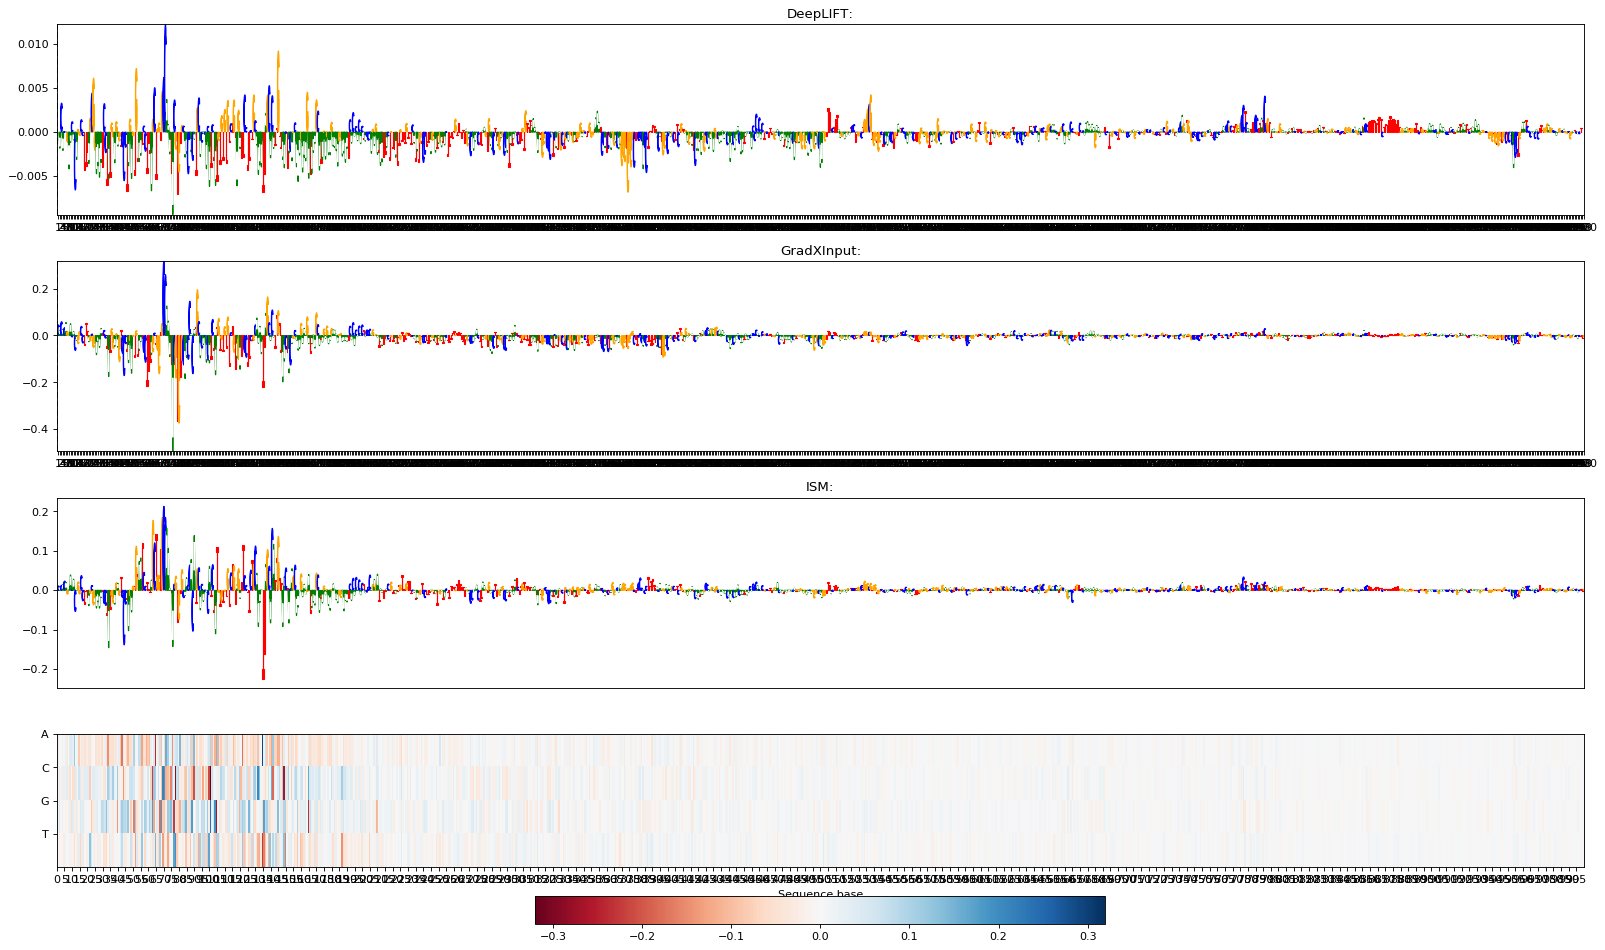

In [17]:
interpretations_A=multi_method_interpret(model,
                                      X['A'],
                                      task_idx=0,
                                      deeplift_score_func=score_func,
                                      target_layer_idx=-1)

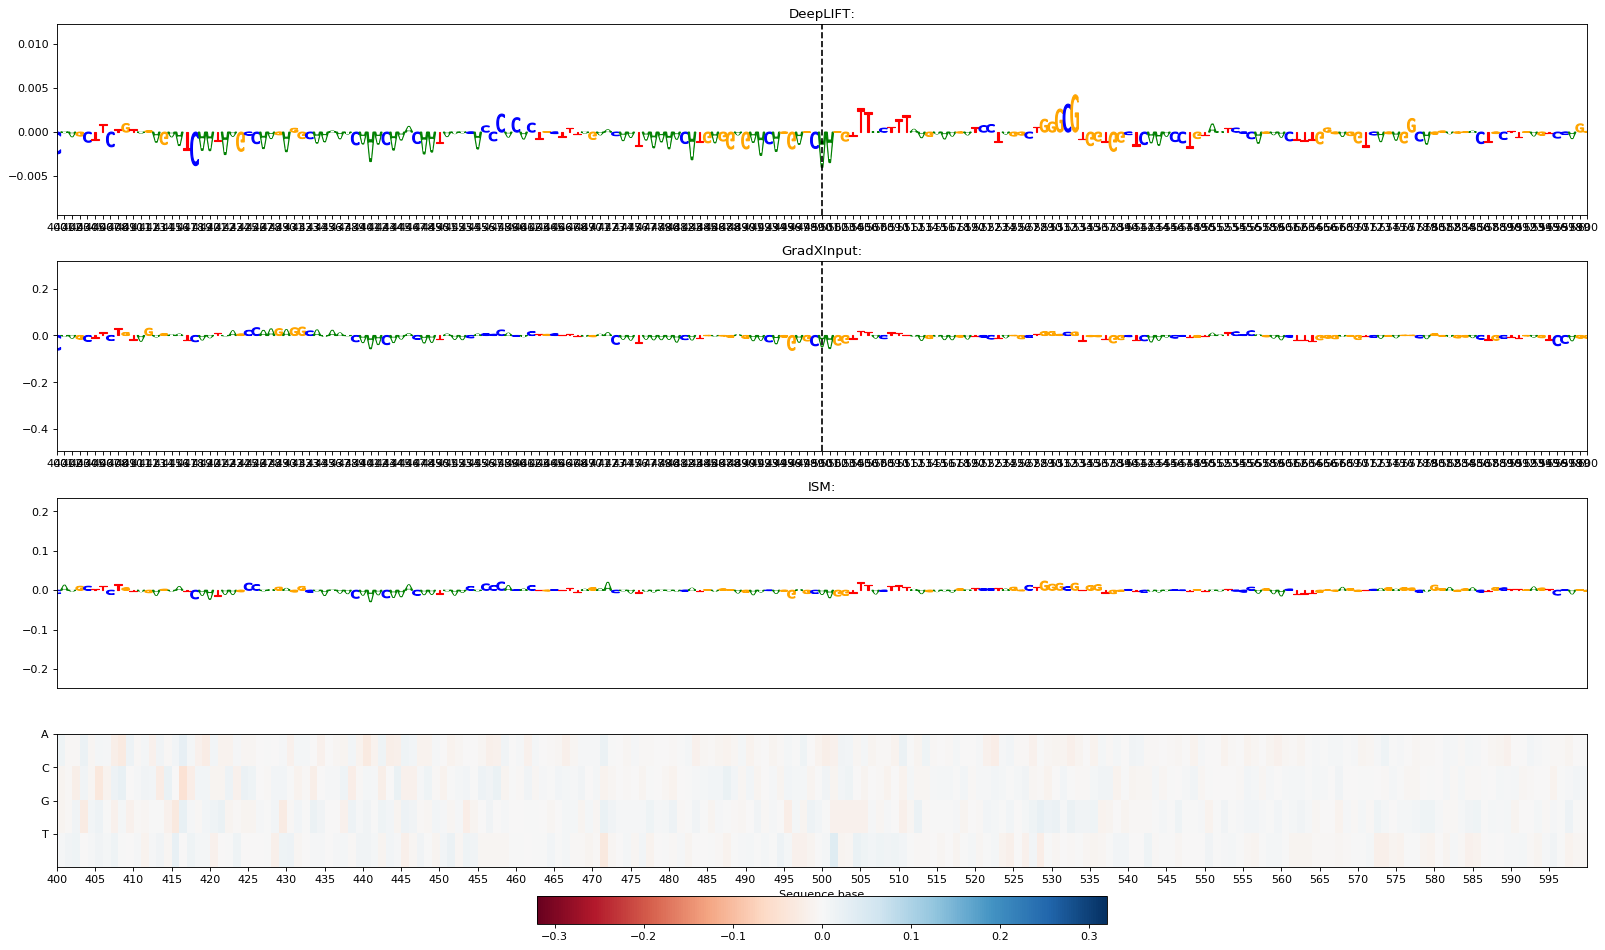

In [20]:
plot_all_interpretations([interpretations_A],X['A'],xlim=(400,600),snp_pos=500)

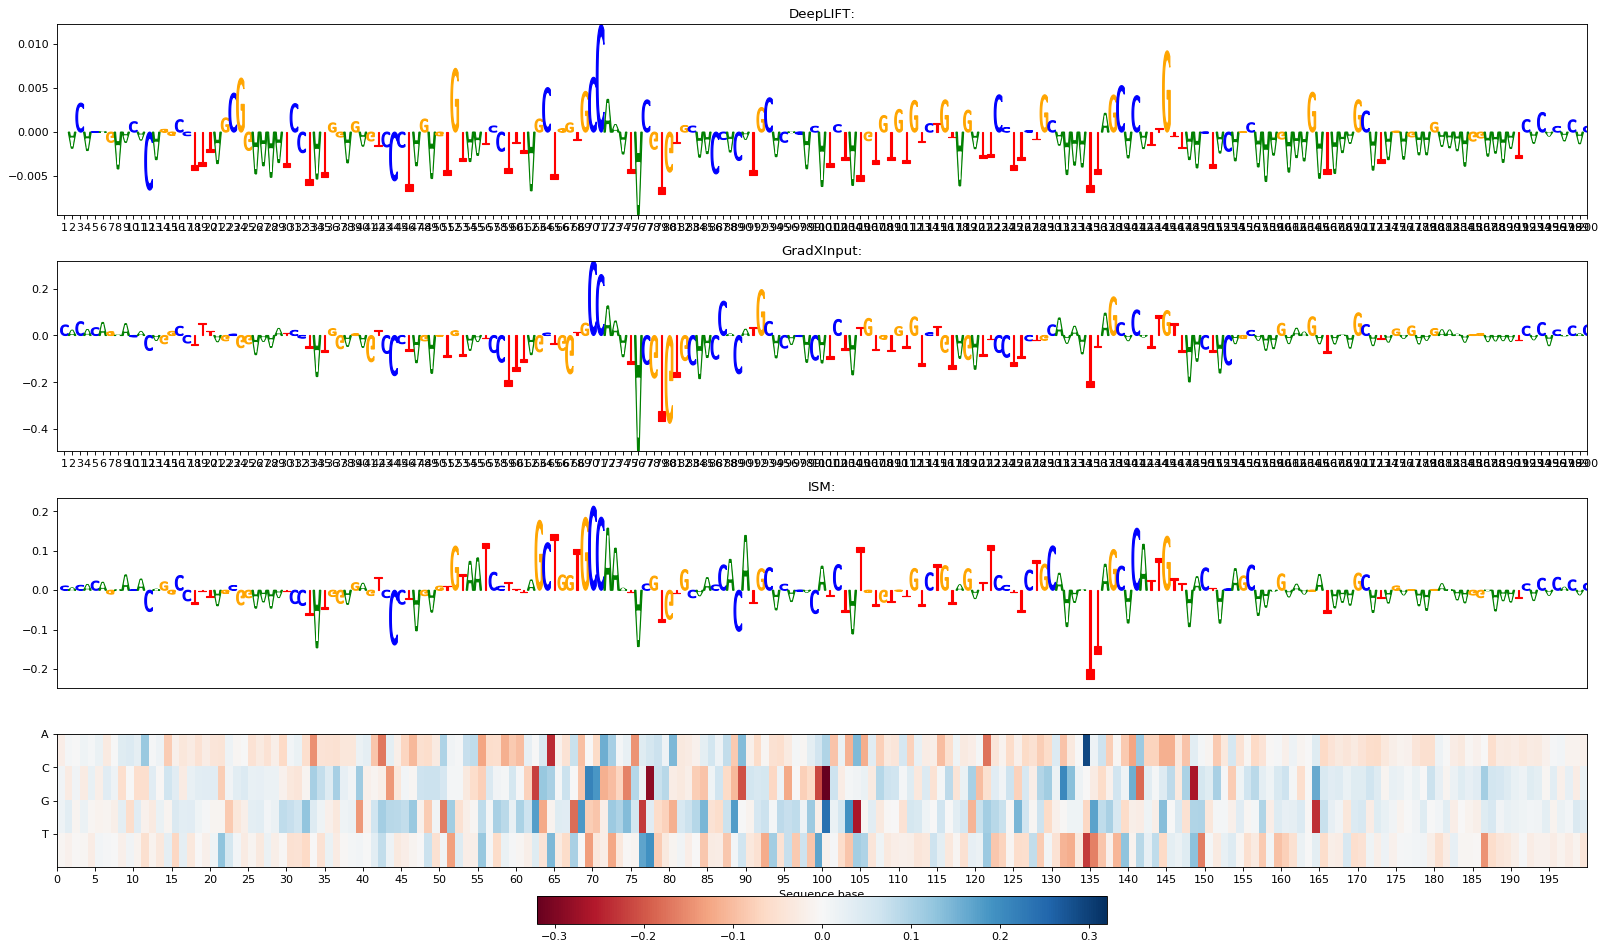

In [21]:
plot_all_interpretations([interpretations_A],X['A'],xlim=(0,200),snp_pos=500)

getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value
getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value
getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


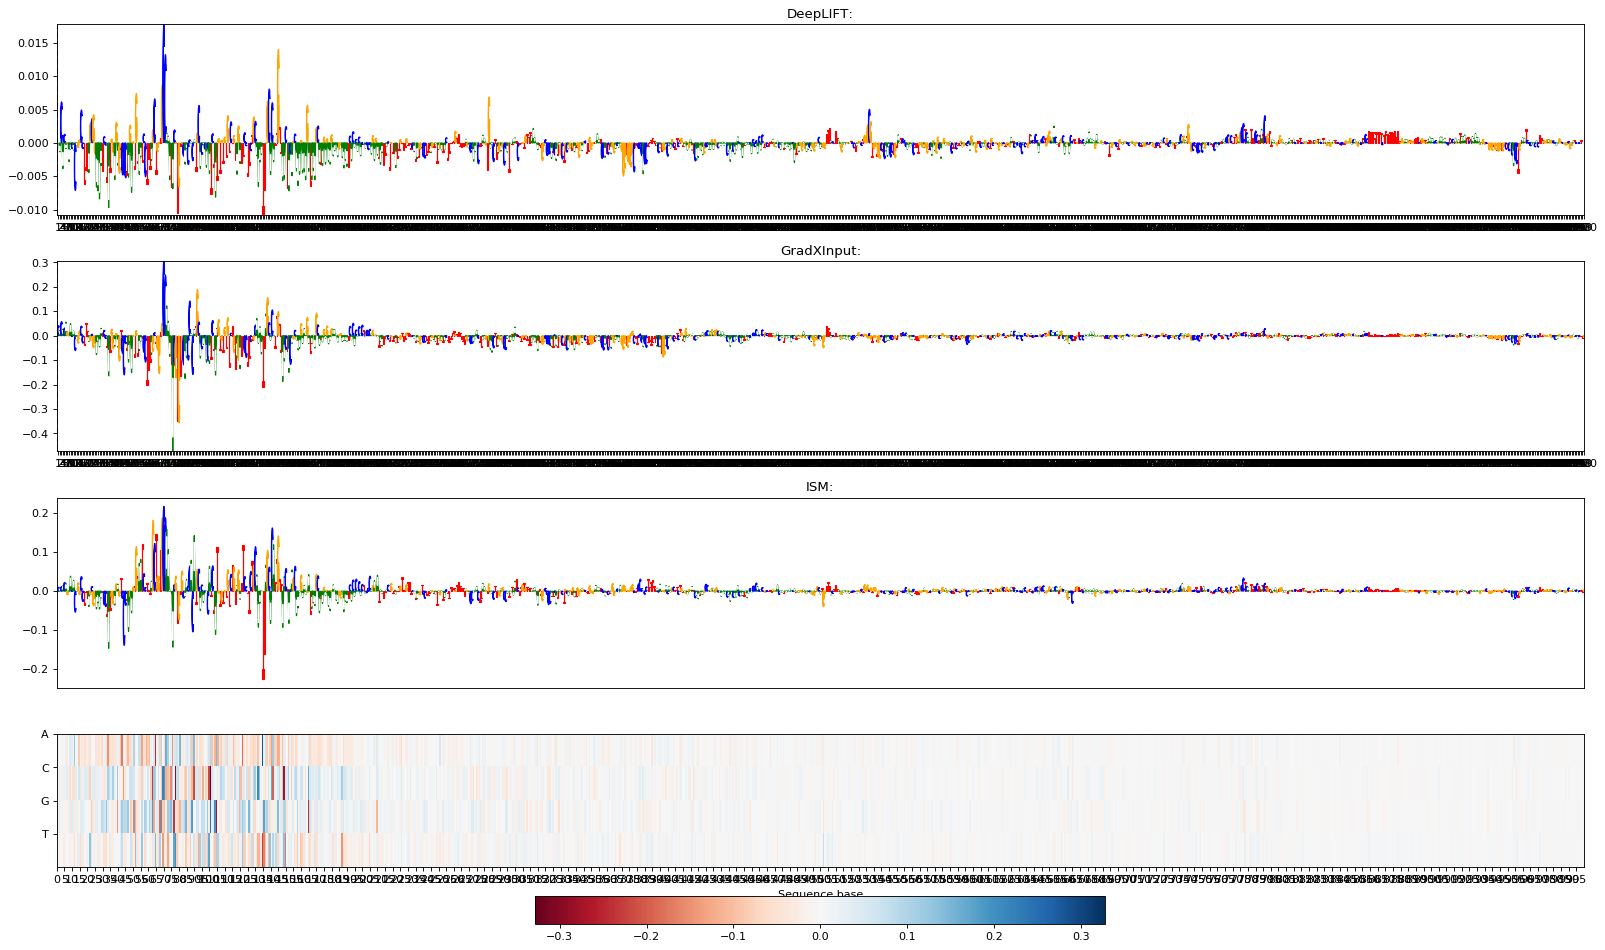

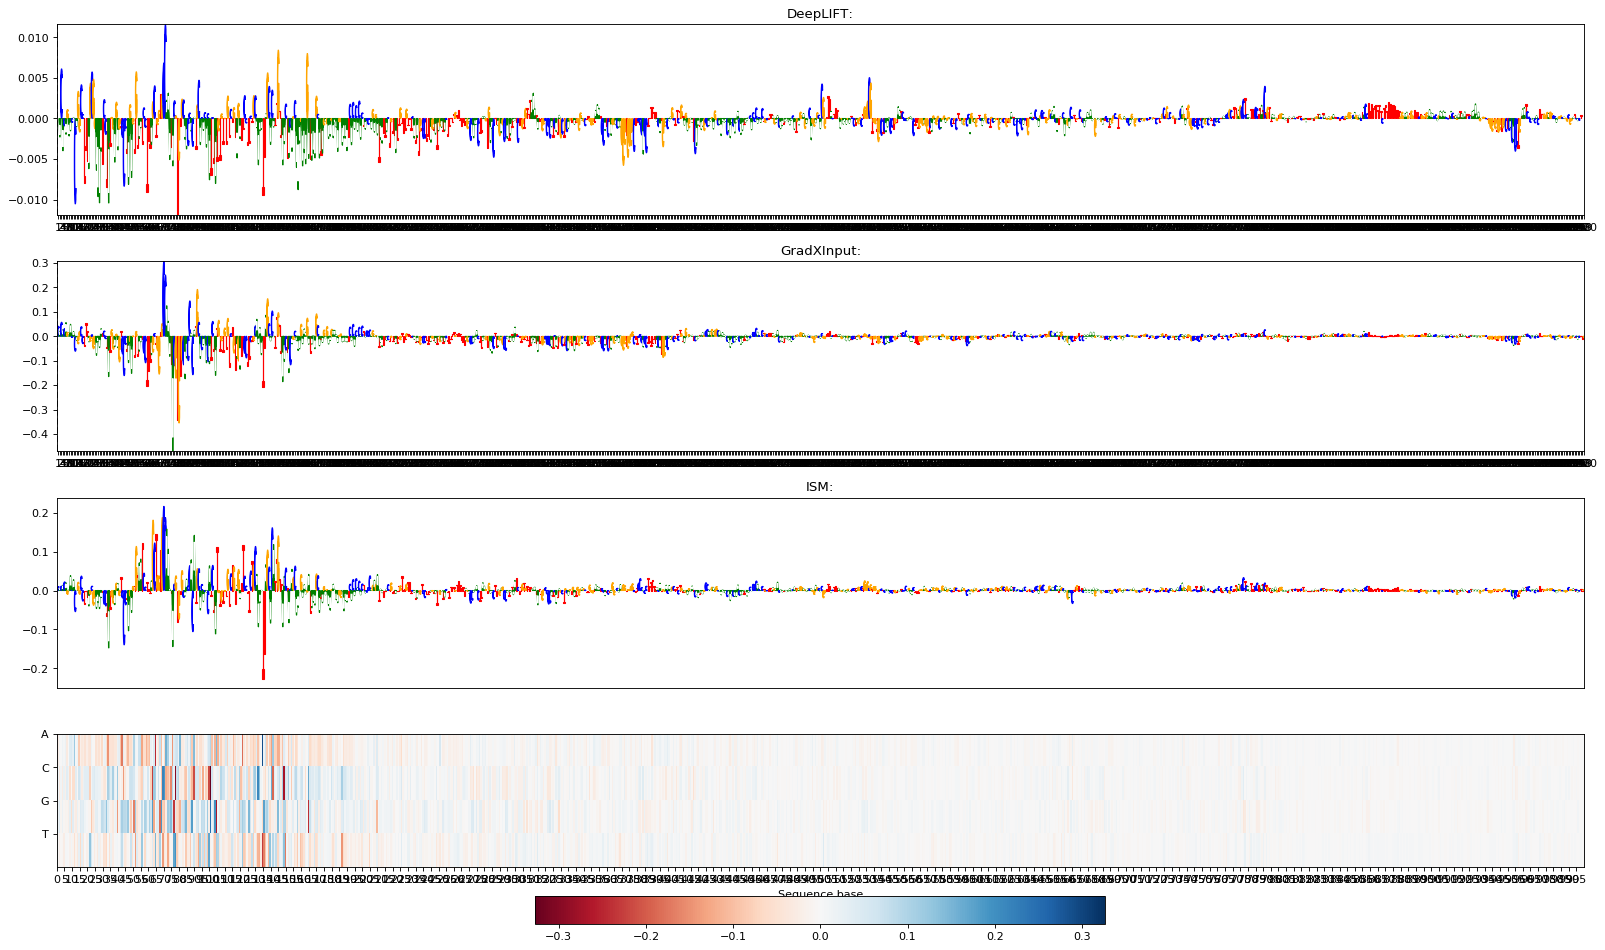

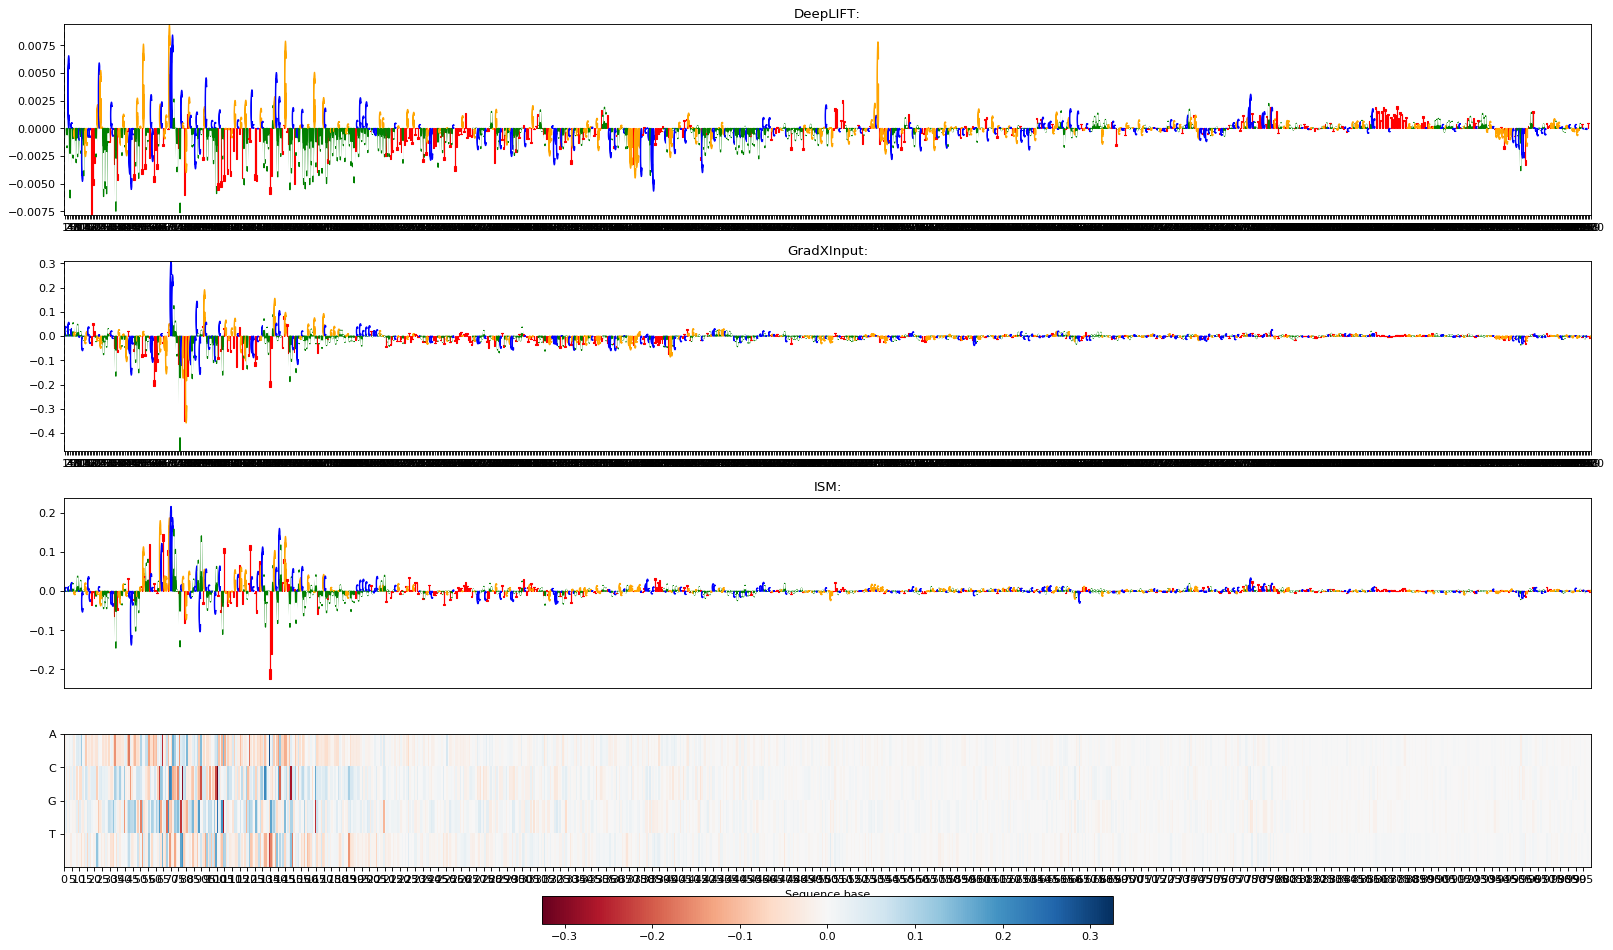

In [22]:
interpretations_T=multi_method_interpret(model,
                                      X['T'],
                                      task_idx=0,
                                      deeplift_score_func=score_func,
                                      target_layer_idx=-1)
interpretations_C=multi_method_interpret(model,
                                      X['C'],
                                      task_idx=0,
                                      deeplift_score_func=score_func,
                                      target_layer_idx=-1)
interpretations_G=multi_method_interpret(model,
                                      X['G'],
                                      task_idx=0,
                                      deeplift_score_func=score_func,
                                      target_layer_idx=-1)

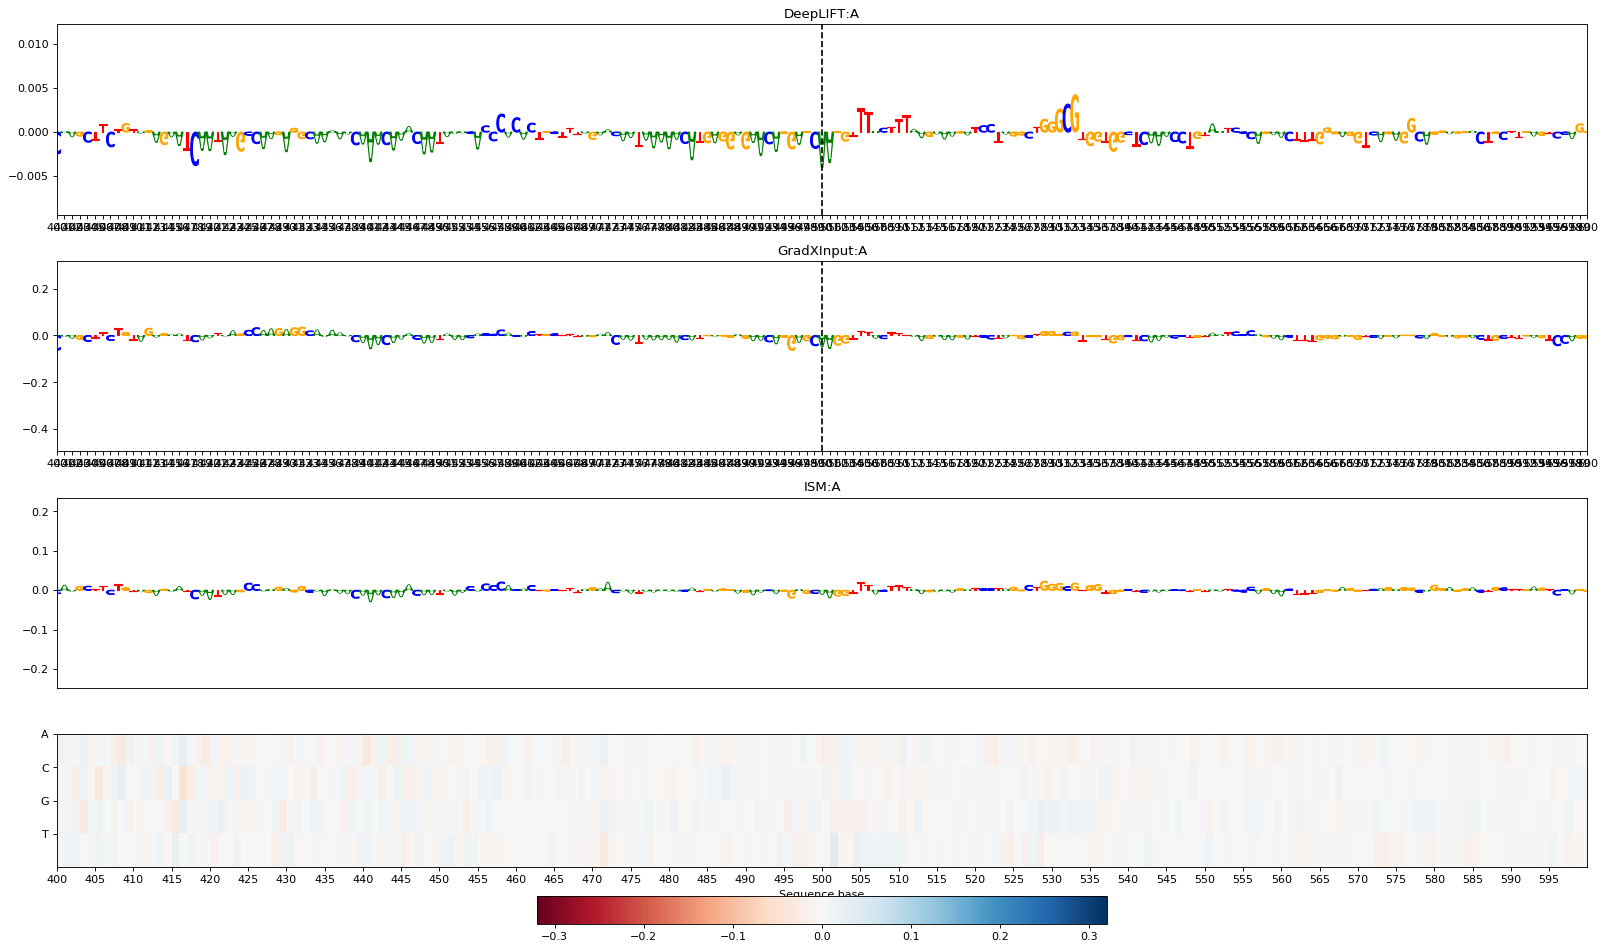

In [23]:
plot_all_interpretations([interpretations_A],X['A'],title="A",xlim=(400,600),snp_pos=500)


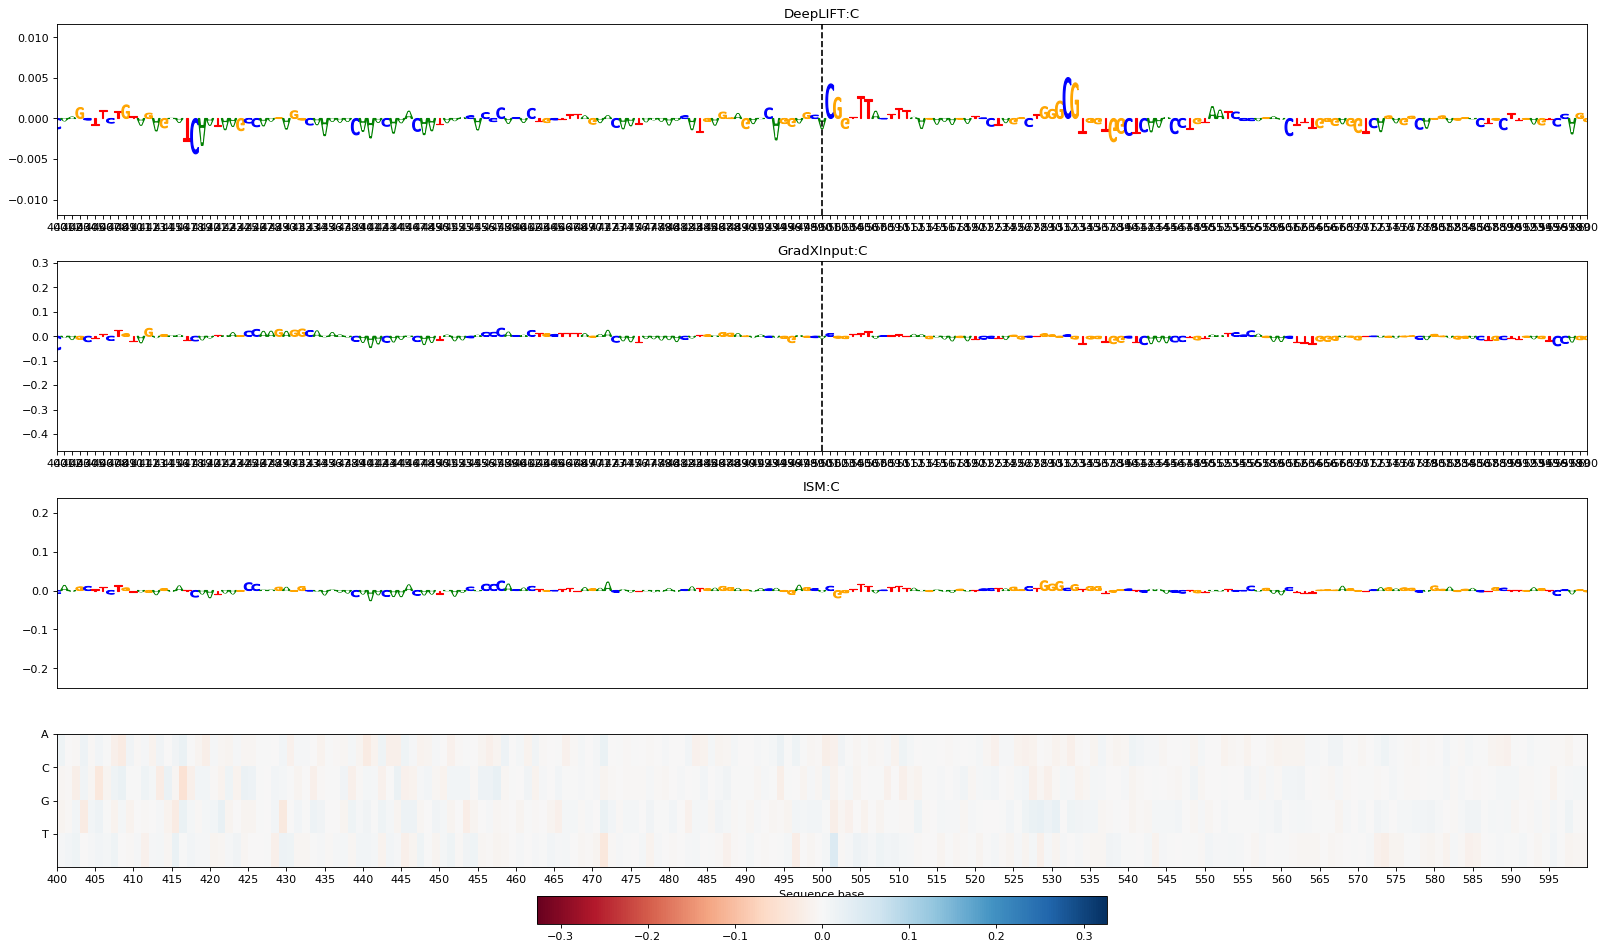

In [24]:
plot_all_interpretations([interpretations_C],X['C'],title="C",xlim=(400,600),snp_pos=500)


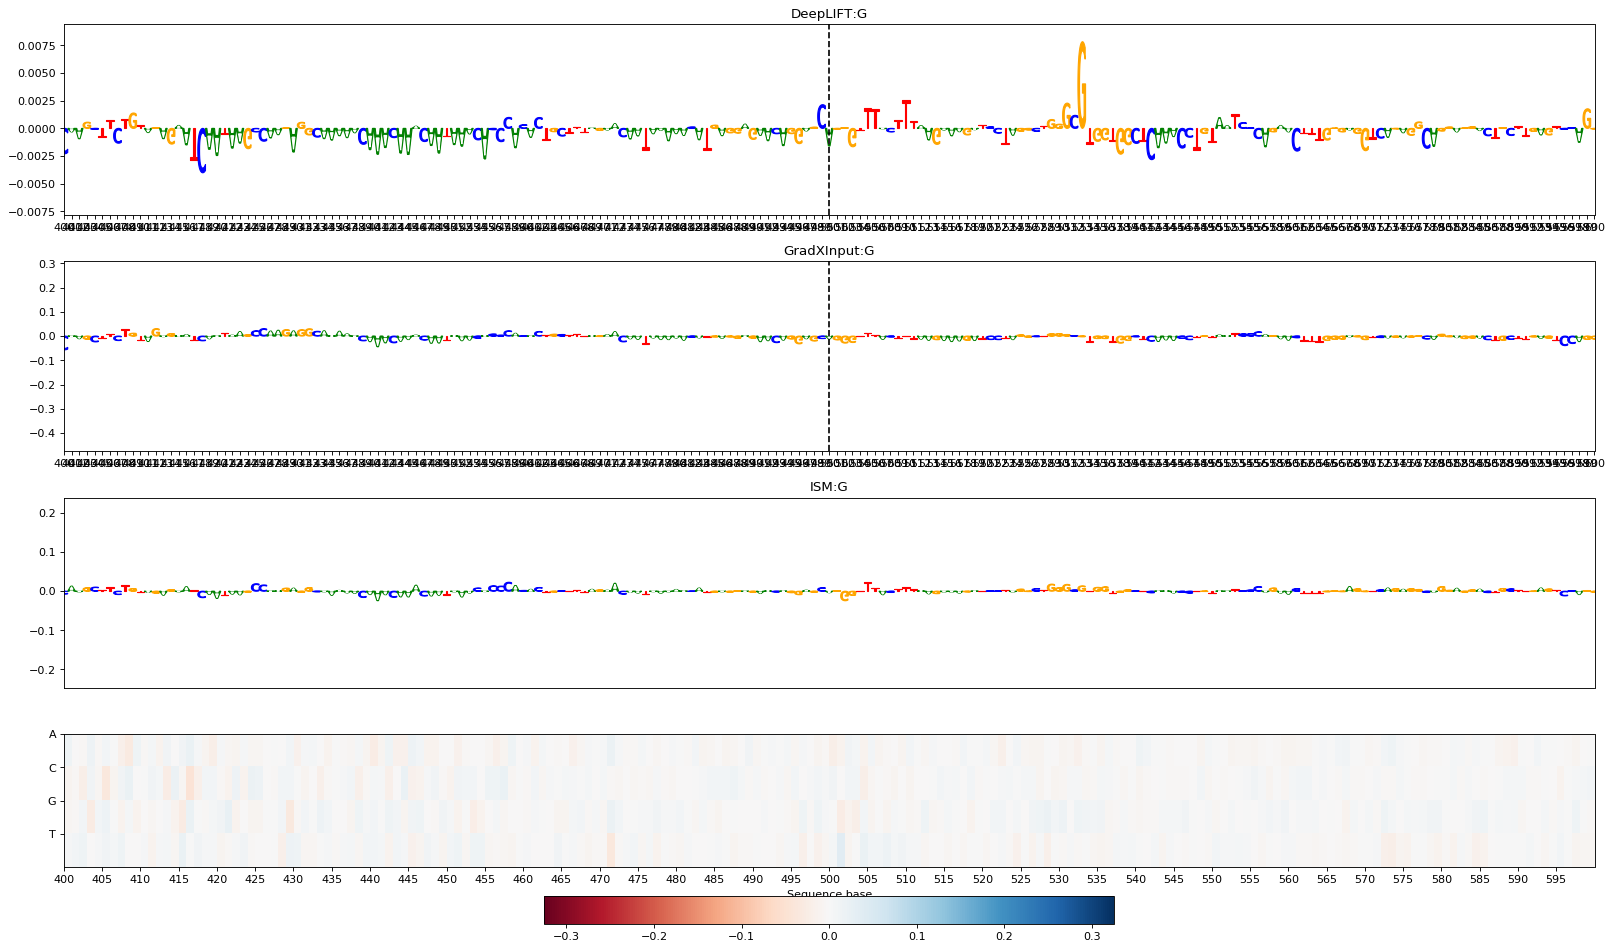

In [25]:
plot_all_interpretations([interpretations_G],X['G'],title="G",xlim=(400,600),snp_pos=500)


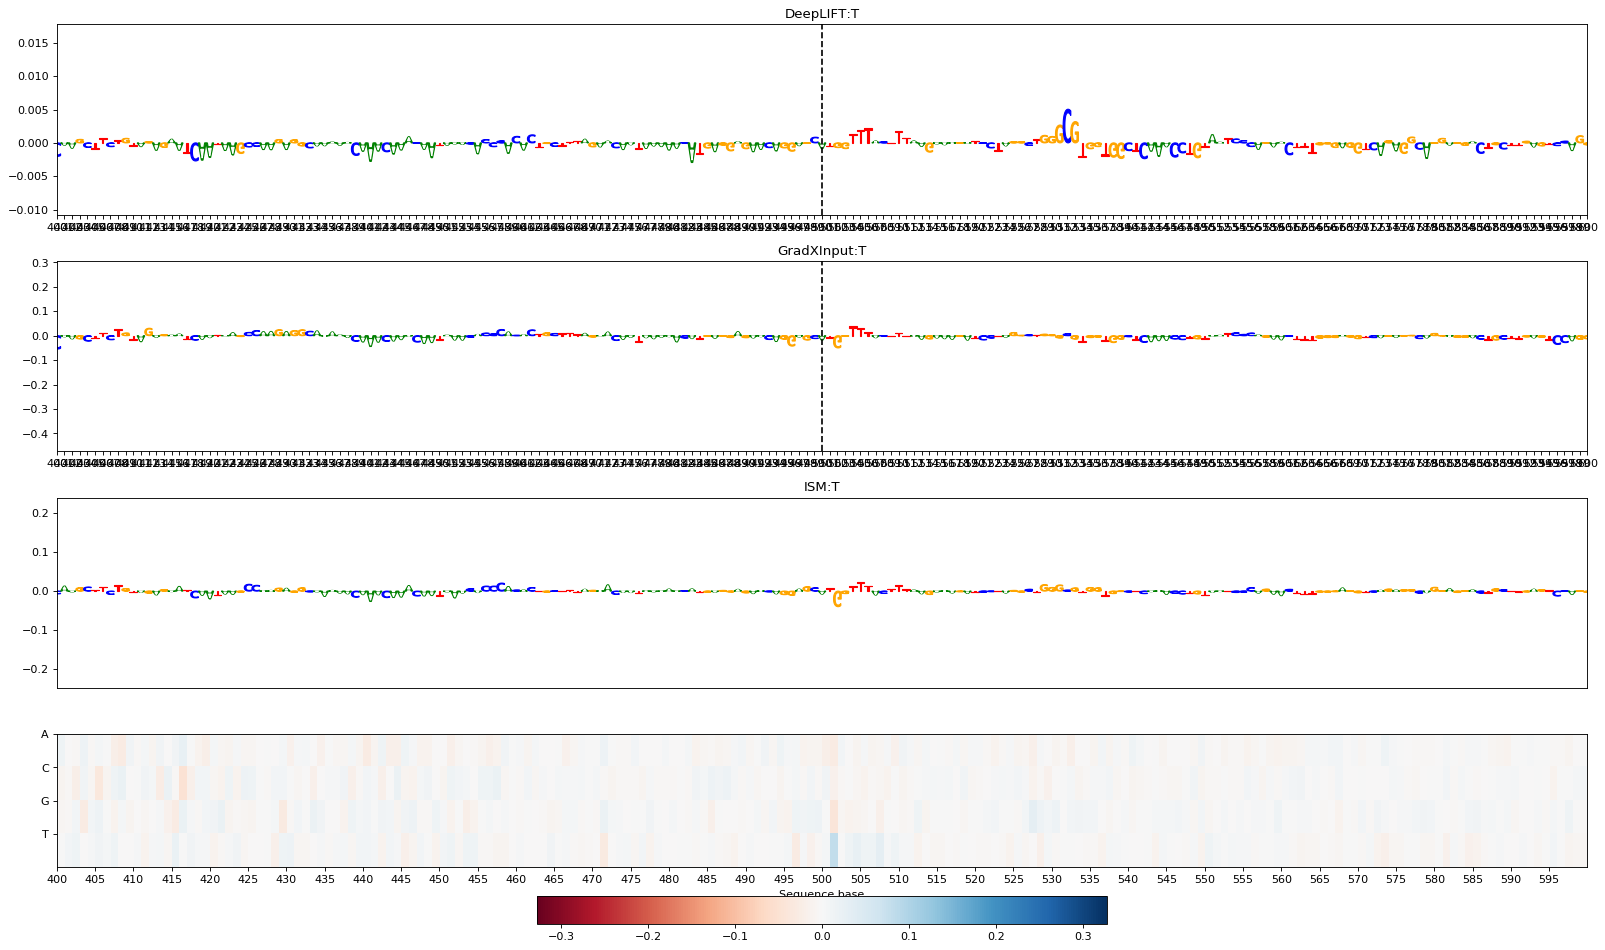

In [26]:
plot_all_interpretations([interpretations_T],X['T'],title="T",xlim=(400,600),snp_pos=500)
